# MSc in AI - CE6002 & CS5062


# E-tivity 5: Higher Dimensions

# CS5062 -Feature Selection - Tasks 1, 2 and 3

## Student Name: Mark Murnane
## Student ID: 18195326
-----

### Import Python modules

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

The following will suppress warnings from sci-kit learn on changes to default values in future releases.

In [2]:
# Don't want FutureWarnings from scikit-learn
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [3]:
wine_df = pd.read_csv("./winequality_red.csv")
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
# Get a quick view of the data
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We can now separate the dataset into _training_ and _test_ sets.

Note that a change from Nik's notebook is the removal from this point of the scaling of the predictor set.  This is moved to apply only to the _training_ set created from `train_test_split`.

In [5]:
# target attribute
target_attribute_name = 'quality'
target = wine_df[target_attribute_name].values

# predictor attributes
predictors = wine_df.drop(target_attribute_name, axis=1).values

### Target Variable Distribution

The initial testing in Task 1 below demonstrates that the models generated have difficulty correctly predicting the target class (with scores of < 60%).

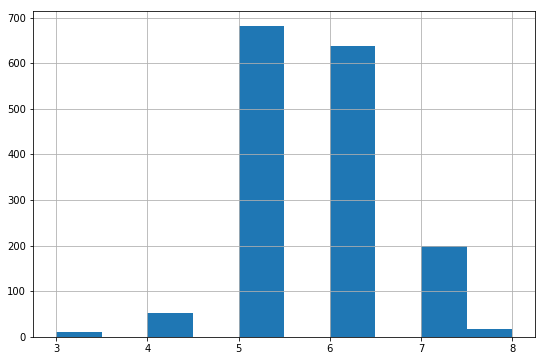

In [6]:
wine_df[target_attribute_name].hist(figsize=(9,6))

As the vast majority of the target values (> 75%) are grouped around the values 5 and 6, it is difficult for the model to discriminate between some of the target values.  

One option to improve this would be to reclassify the quality as either "Poor", "Normal", "Improved". The accuracy of the model is aided by creating larger target "groups" on which to train with such a small training set.  Nik has pointed out that accuracy is not the goal, however.

The more relevant part of the dataset to this exercise is the _predictor_ values.  As can be seen from _describe_ output above and the boxplot below, there are not only different scales in the data set but also large numbers of outliers for several features.

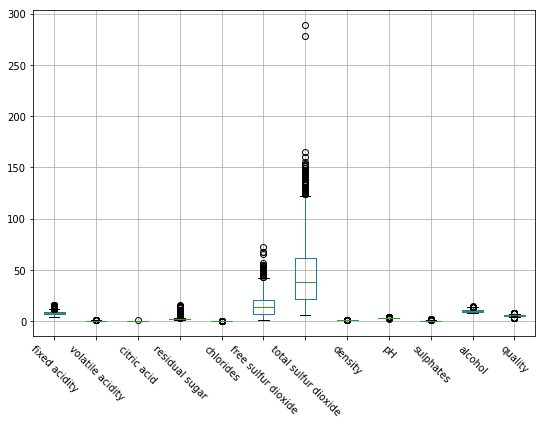

In [7]:
wine_df.boxplot(figsize=(9,6), rot=-45)

# Task 1

Split the data set into a training (80%) and test (20%) data sets.  

We also train a `MinMaxScaler` on the _training_ set and apply it to both the _training_ and _test_ sets.

In [8]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target, random_state=42)

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors_train = min_max_scaler.fit_transform(predictors_train)
predictors_test = min_max_scaler.transform(predictors_test)

## A. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [9]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[4 1 9 5 3 8 2 6 7 1 1]


The output above shows that RFE with SVM has selected the features _volatile acidity_, _sulphates_ and _alcohol_ as the 3 best features for predicting the target classes.

#### 2. Apply RFE with Logistic Regression for selecting the best features

In [10]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[6 1 4 9 7 5 1 3 8 2 1]


The output above shows that RFE with Logistic Regression has selected the features _volatile acidity_, _total suplhur dioxide_ and _alcohol_ as the 3 best features for predicting the target classes.

The change from SVM is the swap of _sulphates_ for _total sulfur dioxide_

## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [11]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [12]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [13]:
classifier = svm.SVC()

In [14]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1.score(predictors_test_SVMselected, target_test)

0.559375

In [15]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2.score(predictors_test_LRselected, target_test)

0.55625

In [16]:
model3 = classifier.fit(predictors_train, target_train)
model3.score(predictors_test, target_test)

0.5625

## C. Conclusion

In this initial run the classifier results show that the classifier with **all** values is actually the best.  The margin to the both the SVM and LogisticRegression selections is small, however, so this may not be indicative.

The similarity of the accuracies across all three models suggests that _volatile acidity_ and _alcohol_ are dominant features in predicting the target _quality_.  The remaining features may add some additional accuracy, but do not make a significant addition to a model's accuracy.

------------

# Task 2


Repeat the experiment from Task 1 in a loop with different training/test stratified splits.

For this task the use of Scikit's `StratifiedKFold` seems to be an appropriate way to split the data.

A hold out set can also be used for testing the optimal model suggested by the K-Fold testing.  As we've already split the data above we can hold on to that split data in the form of `target_train` and `target_test`.

## Loop evaluation for feature selection

While the initial submission used only 5-fold Cross Validation, I've amended this to run the cross-validation loop across multiple different splits of the data.  This is primarily to evaluate the score over a larger number of test runs, as we are not changing the model so there are no "best" parameters to maintain.

The value of 5 for the CV was selected as in some model splits there are < 10 members of a given class available for in the split.  This prompts a warning from scikit-learn.


In [17]:
# Split the data into 5 folds for training.  Have the data shuffled before the split
# Shuffling will also be done by train_test_split so may not be required, but extra shuffle won't hurt

ITERATIONS = 20
SPLITS = 5

strat_fold = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=42)

accuracies_SVM = np.zeros((ITERATIONS,SPLITS))
accuracies_LR = np.zeros((ITERATIONS,SPLITS))
accuracies_ALL = np.zeros((ITERATIONS,SPLITS))

# Need to scale the data separately on each fold
# Redefining here for clarity
min_max_scaler = preprocessing.MinMaxScaler()

# Keep track of fold we're in, just in case
for i in range(ITERATIONS):
    print(f"Processing a set for loop {i}")
    
    # Create a new test_train_split that has not been scaled or otherwise modified
    # No need to use random state, but want to need shuffle in order to stratify
    # Can use more data here too
    predictors_train, predictors_test, target_train, target_test = train_test_split(
                predictors, target, test_size=0.10, shuffle=True, stratify=target, random_state=42)
    
    for fold, (train_idx, validation_idx) in enumerate(strat_fold.split(predictors_train, target_train)):
        # First of all, split this folds data into training and test sets
        fold_X_train, fold_X_val = predictors_train[train_idx], predictors_train[validation_idx]
        fold_y_train, fold_y_val = target_train[train_idx], target_train[validation_idx] 

        fold_X_train = min_max_scaler.fit_transform(fold_X_train)
        fold_X_val = min_max_scaler.transform(fold_X_val)

        # Now that the data is split we can run feature selection as the validation set remains independent of the feature selection
        # The validation set is also transformed based on the training set, but has not influenced that transform
        # As we're repeating the Task 1 experiement, we can re-use the selector objects from above
        fold_train_SVM_predictors = selectorSVM.fit_transform(fold_X_train, fold_y_train)
        fold_val_SVM_predictors = selectorSVM.transform(fold_X_val)

        # Repeat for Logistic Regression
        fold_train_LR_predictors = selectorLR.fit_transform(fold_X_train, fold_y_train)
        fold_val_LR_predictors = selectorLR.transform(fold_X_val)


        # Evaluate the models for this split and store the results
        fold_SVM = classifier.fit(fold_train_SVM_predictors, fold_y_train)
        accuracies_SVM[i][fold] = fold_SVM.score(fold_val_SVM_predictors, fold_y_val)

        fold_LR = classifier.fit(fold_train_LR_predictors, fold_y_train)
        accuracies_LR[i][fold] = fold_LR.score(fold_val_LR_predictors, fold_y_val)

        fold_ALL = classifier.fit(fold_X_train, fold_y_train)
        accuracies_ALL[i][fold] = fold_ALL.score(fold_X_val, fold_y_val)

    print(f"Completed StratifiedKFold processing for loop {i}")

Processing a set for loop 0
Completed StratifiedKFold processing for loop 0
Processing a set for loop 1
Completed StratifiedKFold processing for loop 1
Processing a set for loop 2
Completed StratifiedKFold processing for loop 2
Processing a set for loop 3
Completed StratifiedKFold processing for loop 3
Processing a set for loop 4
Completed StratifiedKFold processing for loop 4
Processing a set for loop 5
Completed StratifiedKFold processing for loop 5
Processing a set for loop 6
Completed StratifiedKFold processing for loop 6
Processing a set for loop 7
Completed StratifiedKFold processing for loop 7
Processing a set for loop 8
Completed StratifiedKFold processing for loop 8
Processing a set for loop 9
Completed StratifiedKFold processing for loop 9
Processing a set for loop 10
Completed StratifiedKFold processing for loop 10
Processing a set for loop 11
Completed StratifiedKFold processing for loop 11
Processing a set for loop 12
Completed StratifiedKFold processing for loop 12
Proces

## Box Plot

Text(0,0.5,'Accuracy/score()')

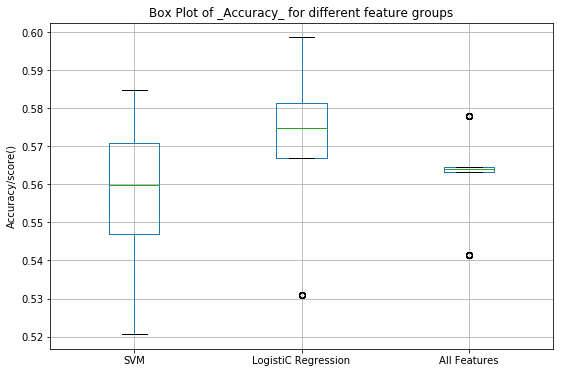

In [18]:
accuracies_df = pd.DataFrame({'SVM':accuracies_SVM.flatten(), 'LogistiC Regression':accuracies_LR.flatten(), 'All Features':accuracies_ALL.flatten()})
ax = accuracies_df.boxplot(figsize=(9,6))
ax.set_title("Box Plot of _Accuracy_ for different feature groups")
ax.set_ylabel("Accuracy/score()")

### Conclusion

The box plot shows that the Logistic Regression selected features outperformed the SVM-selected features as well as the models with no features selected.  It had not only the highest results, but the range of results was higher than the other models. 

The results stands in contrast to Task 1 where the _All features_ model was slightly better.  This experiment appears to confirm the suspicion that the results for _All_ in Task 1 was "lucky" rather than something specific in the feature set.  The improved results for LR in Task 2 confirm that the extra features in _All_ add no benefit in training the model.

# Task 3

Build two pipelines for training classifiers on the *winequality.csv* data set.

-------

For this task I'll increase the number of features selected to 5.  This is to match the number of features that will be supplied to PCA.  In previous exercises with this dataset I performed PCA on the data set and determined that 5 was a good of features/components to select as it represented ~ 90% of the variance in the data.  

![PCAVariance](PCARobustScaler.png)

The diagram above shows the cumulative variance as generated with `RobustScaler` on the dataset.  Due to the high number of outliers this scaler may be more appropriate as `MinMaxScaler` is sensitive to outliers.

This diagram was generated for an exercise in CE4021, with the code available on GitLab [here](https://gitlab.com/CE4021/Group2/project/blob/group_2_2/GroupProject_18195326.ipynb).

See also post to Group 2 Forum under _Tasks 2 and 3 - Scaling_ on [Sulis](https://sulis.ul.ie/x/FSPluK).

In [19]:
# Before processing each pipeline, create a split of the original data
# Avoids any unintentional data snopping from cells above
pipe_X = wine_df.drop('quality', axis=1).values
pipe_y = wine_df['quality']

pipe_X_train, pipe_X_test, pipe_y_train, pipe_y_test = train_test_split(
    pipe_X, pipe_y, test_size=0.20, shuffle=True, stratify=pipe_y, random_state=42)

Note that in both pipelines below, `FeatureUnion` is not necessary as we're not combining multiple feature sets (or output of feature selectors).

For the first pipeline, create a pipeline based on the approach above, which consists of a MinMaxScaler and feature selection using RFE.

In [20]:
# Create the necessary objects for inclusion in the pipeline
min_max = preprocessing.MinMaxScaler()
feature_selector = RFE(LogisticRegression(), 5)
classifier = svm.SVC(kernel='linear')

steps = [('scaler', min_max), ('features', feature_selector), ('clf', classifier)]
pipe = Pipeline(steps)

scores = cross_val_score(pipe, pipe_X_train, pipe_y_train, cv=10)

print(f"The mean of the pipeline's scores is: {scores.mean():.4f}")
print(f"The best of the pipeline's scores is: {scores.max():.4f}")

D:\Masters\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


The mean of the pipeline's scores is: 0.5771
The best of the pipeline's scores is: 0.6457


In [21]:
# Determine the score using the held out test set
pipe.fit(pipe_X_train, pipe_y_train)
pipe.score(pipe_X_test, pipe_y_test)

0.56875

-----
For the second pipeline, we use `RobustScaler` and PCA.  As noted above `RobustScaler` is less sensitive to the outliers in the original data.

In [22]:
# Create the necessary objects for inclusion in the pipeline
rb_scaler = preprocessing.RobustScaler()
feature_selector = PCA(n_components=5)
classifier = svm.SVC(kernel='rbf')

steps = [('scaler', rb_scaler), ('features', feature_selector), ('clf', classifier)]
pipe = Pipeline(steps)

scores = cross_val_score(pipe, pipe_X_train, pipe_y_train, cv=10)

print(f"The mean of the pipeline's scores is: {scores.mean():.4f}")
print(f"The best of the pipeline's scores is: {scores.max():.4f}")

D:\Masters\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


The mean of the pipeline's scores is: 0.5990
The best of the pipeline's scores is: 0.6614


In [23]:
# Determine the score using the held out test set
pipe.fit(pipe_X_train, pipe_y_train)
pipe.score(pipe_X_test, pipe_y_test)

0.615625

### Conclusion

The two pipelines use different scaling and feature selection methods to process the entire dataset. The pipeline that uses PCA produces a better accuracy score.  That indicates that **_for this data set_** the selection based on the cumulative component variance that PCA generates is better than the use of accuracy values by RFE.

The use of pipeline has a number of advantages over the approaches with earlier tasks.  Primarily it avoids the risk of inadvertent snooping while processing the data through the various stages of the pipe.  It also ensures a consistent, repeatable process that can be then applied to out-of-sample data.